# Machine Unlearning Using Influence Functions - MNIST Dataset


## Step 1: Setup and Load Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define transformation and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Data loading complete.")


Data loading complete.


## Step 2: Define the Logistic Regression Model

In [2]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the images
        return self.linear(x)

model = LogisticRegression(28 * 28, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print("Model setup complete.")


Model setup complete.


## Step 3: Train the Model

In [3]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

train_model(model, train_loader, criterion, optimizer)
print("Training complete.")


Epoch [1/5], Loss: 1.0685
Epoch [2/5], Loss: 0.5988
Epoch [3/5], Loss: 0.5056
Epoch [4/5], Loss: 0.4604
Epoch [5/5], Loss: 0.4325
Training complete.


## Step 4: Calculate Influence Functions for Sample Instances

In [4]:
from torch.autograd import grad
import numpy as np

# Helper function for Hessian-vector product calculation
def hvp(loss, model, v):
    grads = grad(loss, model.parameters(), create_graph=True)
    hv = grad(grads, model.parameters(), grad_outputs=v, retain_graph=True)
    return hv

# Function to calculate influence for a single instance
def influence_on_loss(model, instance, label):
    model.eval()
    instance = instance.view(1, -1)  # Flatten the image
    label = torch.tensor([label])
    
    # Forward pass and loss calculation
    output = model(instance)
    loss = criterion(output, label)
    
    # Compute gradients
    grads = grad(loss, model.parameters(), create_graph=True)
    
    # Dummy vector for Hessian-vector product
    v = [torch.ones_like(param) for param in model.parameters()]
    hvp_val = hvp(loss, model, v)
    
    # Estimate influence
    influence = sum((g * h).sum() for g, h in zip(grads, hvp_val))
    return influence.item()

# Sample a subset of instances to calculate influence scores
def calculate_influence_sample(model, train_loader, sample_size=100):
    influence_scores = []
    model.eval()
    
    sample_indices = np.random.choice(len(train_loader.dataset), sample_size, replace=False)
    for idx in sample_indices:
        instance, label = train_loader.dataset[idx]
        influence = influence_on_loss(model, instance, label)
        influence_scores.append((idx, influence))
        
    # Sort by influence magnitude
    influence_scores.sort(key=lambda x: abs(x[1]), reverse=True)
    return influence_scores

# Calculate influence for a sample of 100 instances
sample_influences = calculate_influence_sample(model, train_loader, sample_size=100)
print("Top 5 influential instances (index, influence):", sample_influences[:5])


Top 5 influential instances (index, influence): [(31548, 0.0005491924239322543), (10277, 0.0005024990532547235), (14033, 0.00047708844067528844), (40662, 0.00040207698475569487), (1235, -0.0003747732553165406)]


## Step 5: Implement Machine Unlearning and Retrain the Model

In [5]:
# Remove top 10 high-influence instances
indices_to_remove = [idx for idx, _ in sample_influences[:10]]
unlearned_train_dataset = torch.utils.data.Subset(train_dataset, list(set(range(len(train_dataset))) - set(indices_to_remove)))
unlearned_train_loader = DataLoader(unlearned_train_dataset, batch_size=64, shuffle=True)

# Retrain the model on unlearned dataset
model_unlearned = LogisticRegression(28 * 28, 10)
optimizer = optim.SGD(model_unlearned.parameters(), lr=0.01)
train_model(model_unlearned, unlearned_train_loader, criterion, optimizer)
print("Model retraining complete after unlearning.")


Epoch [1/5], Loss: 1.0662
Epoch [2/5], Loss: 0.5972
Epoch [3/5], Loss: 0.5045
Epoch [4/5], Loss: 0.4596
Epoch [5/5], Loss: 0.4318
Model retraining complete after unlearning.


## Step 6: Evaluate the Model with Detailed Metrics

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation function with multiple metrics
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# Evaluate both models
print("Original model performance:")
original_metrics = evaluate_model(model, val_loader)

print("Unlearned model performance:")
unlearned_metrics = evaluate_model(model_unlearned, val_loader)


Original model performance:
Accuracy: 0.8914, Precision: 0.8911, Recall: 0.8914, F1 Score: 0.8909
Unlearned model performance:
Accuracy: 0.8910, Precision: 0.8909, Recall: 0.8910, F1 Score: 0.8906


## Step 7: Visualize Influence Scores and Performance Impact


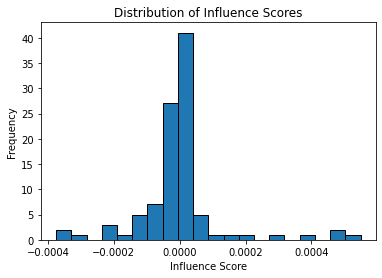

In [7]:
import matplotlib.pyplot as plt

# Plot distribution of influence scores
influences = [score for _, score in sample_influences]
plt.hist(influences, bins=20, edgecolor='black')
plt.xlabel("Influence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Influence Scores")
plt.show()


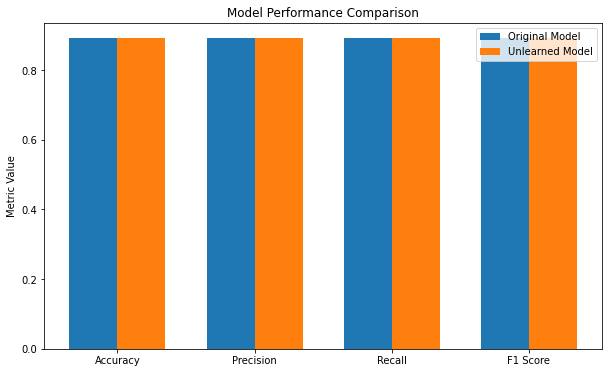

In [8]:
# Plot performance metrics for comparison
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
original_values = original_metrics
unlearned_values = unlearned_metrics

x = np.arange(len(metrics))  # the label locations

# Plot side-by-side bars with an offset for visibility
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, original_values, width, label='Original Model')
ax.bar(x + width/2, unlearned_values, width, label='Unlearned Model')

# Add some labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()